* https://bscscan.com/chart/active-address
* https://stats.avax.network/dashboard/c-chain-activity/
* https://www.statista.com/statistics/1280295/solana-active-addresses/
  * https://graphql.bitquery.io/ide/1OBB1Y2Hv9

In [1]:
import numpy as np
import datetime
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults

In [2]:
STRT_DATE = '2021-01-01 00:00:00'

def getDate(t, strt_date = STRT_DATE):
    return datetime.datetime.strptime(strt_date, "%Y-%m-%d %H:%M:%S") + datetime.timedelta(weeks=t) 

def DMatrix(N):
    x = np.linspace(0, 1, N)
    return np.vstack([x, np.ones(len(x))]).T

def LSquares(A,y):
    pinv = np.linalg.pinv(A)
    return pinv.dot(y)

def Fit_LS(alpha,N=12):
    x = np.linspace(0, 1, N)
    return alpha[0]*x + alpha[1]

In [3]:
avax_addr_arr = np.array([3382,26407,41874,27981,54223,35038,
                          20094,90565,197513,352273,651904,797894])

bnb_addr_arr = np.array([59754,175228,340031,656222,735031,
                        554136,918825,1063933,1045127,1753873,2271060,1193570])

sol_addr_arr = np.array([1886577,1279429,2002448,2187755,1970016,1841008,
                        1932891,2179934,2184075,2297492,2325532,2348665])

In [4]:
alpha_avax = LSquares(DMatrix(12),avax_addr_arr)
alpha_bnb = LSquares(DMatrix(12),bnb_addr_arr)
alpha_sol = LSquares(DMatrix(12),sol_addr_arr)

avax_fit = Fit_LS(alpha_avax,N=12)
bnb_fit = Fit_LS(alpha_bnb,N=12)
sol_fit = Fit_LS(alpha_sol,N=12)

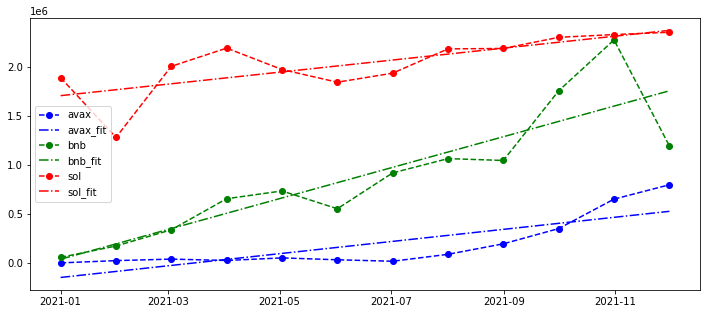

In [5]:
fit_dates = np.array([getDate(k*52/12) for k in range(12)])
pred_dates = np.array([getDate(k*52/12) for k in range(12,24)])

fig = plt.figure(figsize=(12, 5))
plt.plot(fit_dates, avax_addr_arr, linestyle='--',marker='o',label='avax',color='blue')
plt.plot(fit_dates, Fit_LS(alpha_avax,N=12), linestyle='-.',label='avax_fit',color='blue')

plt.plot(fit_dates, bnb_addr_arr, linestyle='--',marker='o',label='bnb',color='green')
plt.plot(fit_dates, Fit_LS(alpha_bnb,N=12), linestyle='-.',label='bnb_fit',color='green')

plt.plot(fit_dates, sol_addr_arr, linestyle='--',marker='o',label='sol',color='red')
plt.plot(fit_dates, Fit_LS(alpha_sol,N=12), linestyle='-.',label='sol_fit',color='red')
plt.legend();

In [6]:
print("{:.0f} new addresses per month on solana".format(alpha_sol[0]/12)) 
print("{:.0f} new addresses per month on bnb".format(alpha_bnb[0]/12))
print("{:.0f} new addresses per month on avax".format(alpha_avax[0]/12))

55341 new addresses per month on solana
142716 new addresses per month on bnb
56037 new addresses per month on avax


In [7]:
raw_data = np.array([bnb_addr_arr,avax_addr_arr,sol_addr_arr])
trend_data = np.array([bnb_fit,avax_fit,sol_fit])
C = covMatrix = np.cov(trend_data,bias=True)
print(C)

[[2.88851761e+11 1.13417672e+11 1.12008679e+11]
 [1.13417672e+11 4.45334597e+10 4.39802187e+10]
 [1.12008679e+11 4.39802187e+10 4.34338506e+10]]


In [8]:
trend_df = pd.DataFrame({'bnb':bnb_fit,'avax':avax_fit,'sol':sol_fit})
raw_df = pd.DataFrame({'bnb':bnb_addr_arr,'avax':avax_addr_arr,'sol':sol_addr_arr})

In [9]:
model = VAR(endog=trend_df)    
model_fit = model.fit(2)

In [10]:
n_pred = 12
trend_pred= pd.DataFrame(model_fit.forecast(raw_df.values, steps=n_pred))
bnb_pred = trend_pred.loc[:,0]
avax_pred = trend_pred.loc[:,1]
sol_pred = trend_pred.loc[:,2]

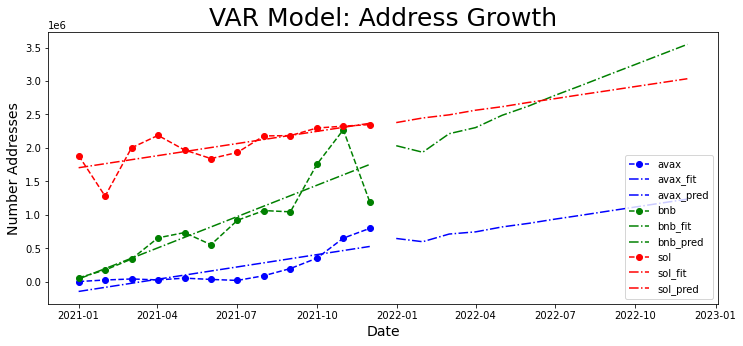

In [11]:
fig = plt.figure(figsize=(12, 5))
plt.title('VAR Model: Address Growth', fontsize=25)
plt.ylabel('Number Addresses', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.plot(fit_dates, avax_addr_arr, linestyle='--',marker='o',label='avax',color='blue')
plt.plot(fit_dates, Fit_LS(alpha_avax,N=12), linestyle='-.',label='avax_fit',color='blue')
plt.plot(pred_dates, avax_pred, linestyle='-.',label='avax_pred',color='blue')

plt.plot(fit_dates, bnb_addr_arr, linestyle='--',marker='o',label='bnb',color='green')
plt.plot(fit_dates, Fit_LS(alpha_bnb,N=12), linestyle='-.',label='bnb_fit',color='green')
plt.plot(pred_dates, bnb_pred, linestyle='-.',label='bnb_pred',color='green')

plt.plot(fit_dates, sol_addr_arr, linestyle='--',marker='o',label='sol',color='red')
plt.plot(fit_dates, Fit_LS(alpha_sol,N=12), linestyle='-.',label='sol_fit',color='red')
plt.plot(pred_dates, sol_pred, linestyle='-.',label='sol_pred',color='red')
plt.legend();

fig.savefig('../img/address_growth.png')

In [12]:
from pymc3.gp.util import plot_gp_dist
import numpy as np
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt

In [38]:
def scaleX(x):
    return list(x/np.sum(x))

def rBeta(a,b):
    return np.random.beta(a,b)

def getStats(arr):    
    upr = np.quantile(arr, 0.95)
    mu = np.quantile(arr, 0.5)
    lwr = np.quantile(arr, 0.05)
    return np.array([mu, lwr, upr])

def markovChain(state, M, N = 11, P0 = []):   
    stateHist=state
    dfStateHist=pd.DataFrame(state)
    distr_hist = [[0,0,0]]
    burned_minted = np.array([0])
    green_minted = np.array([0]) 
    for x in range(N):
        P = genTransMatrix() if len(P0) == 0 else P0      
        P_scale = np.multiply(P, M)
        state = np.dot(state, P_scale)
        portion = np.array([[0.01, 0.01, 0.01]])
        state = state + portion*np.array([[bnb_pred[x], avax_pred[x], sol_pred[x]]])
        stateHist = np.append(stateHist, state, axis=0)
        
    dfDistrHist = pd.DataFrame(stateHist)    
    dfDistrHist.columns = ['Binance', 'Avax', 'Solana'] 
      
    return dfDistrHist   

def genTransMatrix():
    
    P = np.array([[rBeta(9,1), rBeta(1,19), rBeta(1,19)],
                 [rBeta(1,19), rBeta(9,1), rBeta(1,19)],
                 [rBeta(1,19), rBeta(1,19), rBeta(9,1)]])

    return np.array(list(map(scaleX, P)))   

In [162]:
np.arange(2,12,3)

array([ 2,  5,  8, 11])

In [173]:
binance_arr.astype(int)

array([258861, 214708, 307371])

In [174]:
stats = np.array([]);

for k in np.arange(2,12,3):
    binance_arr = np.array([np.quantile(binance[k], 0.5), 
                              np.quantile(binance[k], 0.05), 
                              np.quantile(binance[k], 0.95)]).astype(int)
    avax_arr = np.array([np.quantile(avax[k], 0.5), 
                              np.quantile(avax[k], 0.05), 
                              np.quantile(avax[k], 0.95)]).astype(int)
    solana_arr = np.array([np.quantile(solana[k], 0.5), 
                              np.quantile(solana[k], 0.05), 
                              np.quantile(solana[k], 0.95)]).astype(int) 
    stats_matrix = np.hstack((binance_arr, avax_arr, solana_arr))
    stats = np.append(stats,stats_matrix)
    
stats = stats.reshape((4, 9))  

colnms = np.array(['BNB','BNB_lwr','BNB_upr',
                   'AVA','AVA_lwr','AVA_upr',
                   'SOL','SOL_lwr','SOL_upr'])

stats_df = pd.DataFrame(stats,columns = colnms)

In [175]:
stats_df

,BNB,BNB_lwr,BNB_upr,AVA,AVA_lwr,AVA_upr,SOL,SOL_lwr,SOL_upr
0,38922.0,36499.0,41632.0,13817.0,12542.0,17755.0,46987.0,44950.0,49457.0
1,107236.0,95902.0,117988.0,48791.0,40762.0,65561.0,114278.0,99723.0,122030.0
2,182091.0,150159.0,207789.0,91862.0,73828.0,110034.0,183929.0,161676.0,221580.0
3,258861.0,214708.0,307371.0,160585.0,127698.0,199374.0,258262.0,203520.0,310233.0


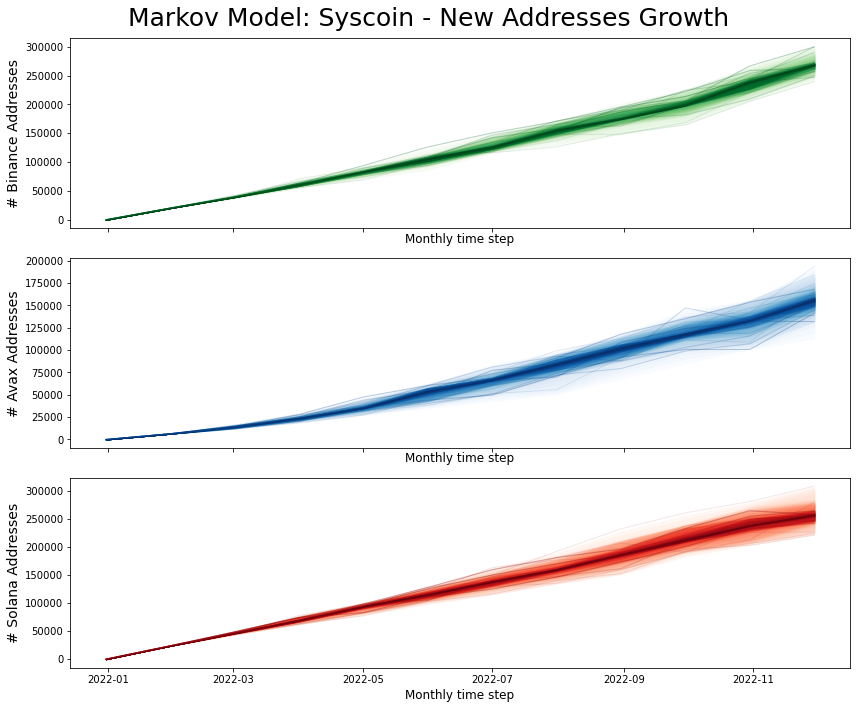

In [176]:
N = 11
M = np.repeat(1,9).reshape((3, 3)); M[1,0] = 1
state = np.array([[0.0, 0.0, 0.0]])

dfDistrHist = markovChain(state, M, N)
binance = dfDistrHist.Binance.values.reshape(-1,1)
avax = dfDistrHist.Avax.values.reshape(-1,1)
solana = dfDistrHist.Solana.values.reshape(-1,1)

for k in range(1,25):
    dfDistrHist = markovChain(state, M, N)
    binance = np.hstack((binance, dfDistrHist.Binance.values.reshape(-1,1)))
    avax = np.hstack((avax, dfDistrHist.Avax.values.reshape(-1,1)))
    solana = np.hstack((solana, dfDistrHist.Solana.values.reshape(-1,1)))

fig, (bnb_ax, avax_ax, sol_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(12, 10))
fig.suptitle('Markov Model: Syscoin - New Addresses Growth', fontsize=25)
plot_gp_dist(bnb_ax, binance.transpose(), pred_dates, palette="Greens")
bnb_ax.set_xlabel("Monthly time step", fontsize=12)
bnb_ax.set_ylabel("# Binance Addresses", fontsize=14)  

plot_gp_dist(avax_ax, avax.transpose(), pred_dates, palette="Blues")
avax_ax.set_xlabel("Monthly time step", fontsize=12)
avax_ax.set_ylabel("# Avax Addresses", fontsize=14)    

plot_gp_dist(sol_ax, solana.transpose(), pred_dates, palette="Reds")
sol_ax.set_xlabel("Monthly time step", fontsize=12)
sol_ax.set_ylabel("# Solana Addresses", fontsize=14)
fig.savefig('../img/syscoin_address_growth.png')
plt.tight_layout()
